# Affine transforms
This notebook demonstrates how to apply affine transforms to 3D images.

In [1]:
import pyclesperanto_prototype as cle

cle.select_device('RTX')

<NVIDIA GeForce RTX 3050 Ti Laptop GPU on Platform: NVIDIA CUDA (1 refs)>

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imshow, imread

In [3]:
# Laod example data
input_image = imread("../../data/Haase_MRT_tfl3d1.tif")
input_image.shape

(120, 160, 160)

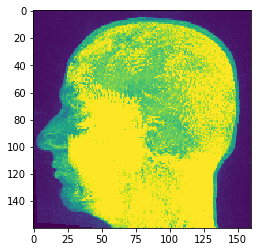

In [4]:
cle.imshow(input_image)

## Rotation
For rotating an image, you need to provide angles corresponding to axes.

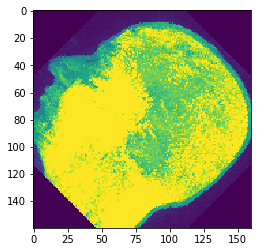

In [5]:
rotated = cle.rotate(input_image, angle_around_z_in_degrees=45)
cle.imshow(rotated)

Images are rotated around their center by default. You can change this by providing an additional parameter. The image will then be rotated around the origin.

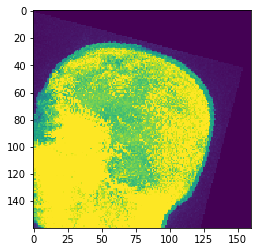

In [6]:
rotated = cle.rotate(input_image, angle_around_z_in_degrees=15, rotate_around_center=False)
cle.imshow(rotated)

## Translation
Images can be translate by providing translation distances along axes:

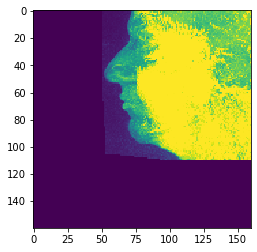

In [7]:
translated = cle.translate(input_image, translate_x=50, translate_y=-50)
cle.imshow(translated)

## Scaling
You can scale the image by providing scaling factors.

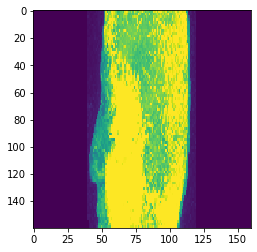

In [8]:
scaled = cle.scale(input_image, factor_x=0.5, factor_y=2)
cle.imshow(scaled)

## Auto-size
Especially for scaling, the `auto_size` parameter may be helpful:

In [19]:
scaled = cle.scale(input_image, factor_x=0.5, factor_y=2, auto_size=True)
cle.imshow(scaled)

TypeError: got an unexpected keyword argument 'auto_size'

## Rigid transform
Rigid transforms allow to do translations and rotations in one shot

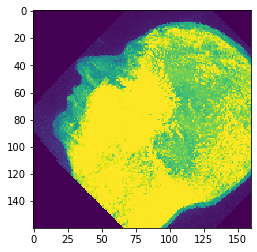

In [9]:
rigid_transformed = cle.rigid_transform(input_image, translate_x=20, angle_around_z_in_degrees=45)
cle.imshow(rigid_transformed)

## Affine transforms
To do translation, rotation and scaling in one shot, use affine transforms. [Shearing will be implemented in a future release](https://github.com/clEsperanto/pyclesperanto_prototype/issues/90).

To setup an affine transform, you can do this using a 4x4 transform matrix:

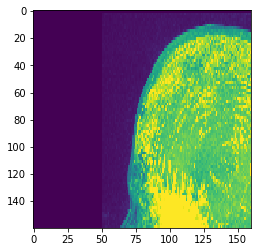

In [10]:
transform_matrix = np.asarray([
    [1, 0, 0, 50],
    [0, 2, 0, 0],
    [0, 0, 0.5, 0],
    [0, 0, 0, 1]
])
transformed_image = cle.affine_transform(input_image, transform=transform_matrix)
cle.imshow(transformed_image)

Alternatively, you can configure a transform object and pass it:

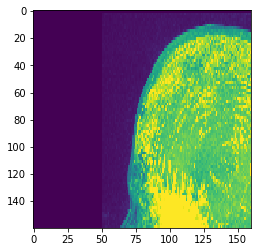

In [11]:
transform = cle.AffineTransform3D()
transform.translate(50)
transform.scale(1, 2, 0.5)

transformed_image = cle.affine_transform(input_image, transform=transform)
cle.imshow(transformed_image)

### Shearing
Providing the shear angle will shear the image in the desired plane

xy


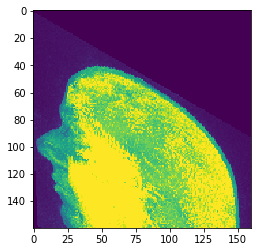

yz


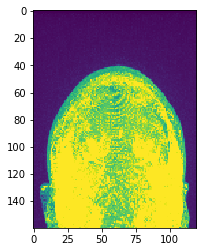

xz


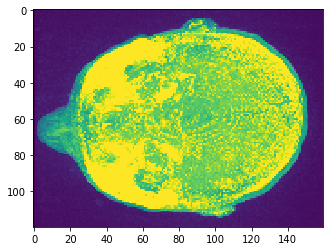

In [12]:
#For example, to shear the image in the Y axis along XY-plane using a shear angle of 30 degrees
shear_angle = 30.0

transform = cle.AffineTransform3D()
shear_transform= transform.shear_in_z_plane(angle_y_in_degrees=shear_angle)

transformed_image = cle.affine_transform(input_image, transform=shear_transform)

##display images in each plane
print("xy")
cle.imshow(cle.maximum_z_projection(transformed_image))
print("yz")
cle.imshow(cle.maximum_x_projection(transformed_image))
print("xz")
cle.imshow(cle.maximum_y_projection(transformed_image))

# Interoperability with scikit-image
Scikit-image only supports 2D transforms and thus, we pick a slice to transform it:

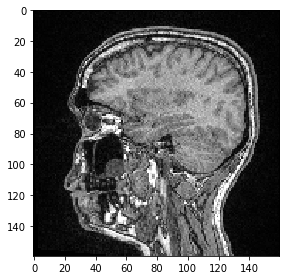

In [13]:
# pull image stack from GPU and pick a slice
image = cle.pull_zyx(input_image)[80]

from skimage.io import imshow
imshow(image)

We now define an affine transform using scikit-image and apply it to the image.

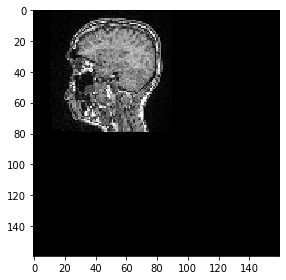

In [14]:
from skimage import transform as tf

# define transform with #scikit image
transform = tf.AffineTransform(scale=0.5, translation=[10,0])

transformed_image = tf.warp(image, transform.inverse)
imshow(transformed_image)

Next, we push this single plane image to the GPU and transform it using pyclesperanto

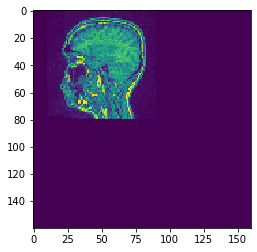

In [15]:
image_gpu = cle.push_zyx(image)

# define transform with #scikit image
from skimage import transform as tf
transform = tf.AffineTransform(scale=0.5, translation=[10,0])

transformed_image = cle.affine_transform(image_gpu, transform=transform)
cle.imshow(transformed_image)

# Linear interpolation versus nearest neighbor interpolation
Let's crop the nose and transform it using different interpolation modes.

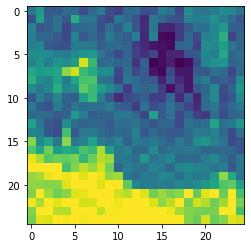

shape (25, 25, 25)


In [16]:
crop = cle.crop(input_image, start_x=45, start_y=125, start_z=50, width=25, height=25, depth=25)
cle.imshow(crop)
print("shape", crop.shape)

# Nearest neighbor interpolation

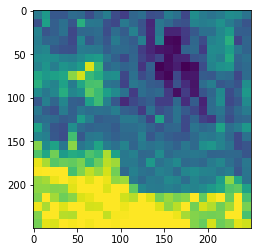

In [17]:
# create a larger image
rescaled = cle.create(np.asarray(crop.shape) * 10)

# fill it with a scaled version of the image; 
cle.scale(crop, rescaled, factor_x=10, factor_y=10, factor_z=10, linear_interpolation=False)
cle.imshow(rescaled)

### Linear interpolation

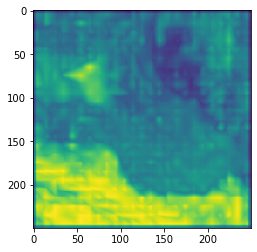

In [18]:
# fill it with a scaled version of the image; 
cle.scale(crop, rescaled, factor_x=10, factor_y=10, factor_z=10, linear_interpolation=True)
cle.imshow(rescaled)